# Homework 1
***

We are going to work with the following dataset: fluid current in a tube.
Some statistics are collected for dataset, incl. mean, skewness, kurtosis, etc. We are predicting flow rate ('tohn/hour'). We need to build confidence and predictive intervals.

In [59]:
!pip install math

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [5]:
%matplotlib inline

import numpy as np
from sklearn import datasets, linear_model, preprocessing, model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
df = pd.read_csv('exxsol_data.csv', sep=';', header=(0))

There are 10 features and 1 label to predict:

In [7]:
print(df.columns.values)

['mean' 'std' 'skew' 'kurt' 'RMS' 'crest' 'freq_peak' 'shan' 'perm' 'temp'
 'tohn/hour']


In [8]:
y = df['tohn/hour']
freq_temp = df[['freq_peak','temp']]

Physics tells us that flow rate is a function of a frequency peak and temperature.

In [9]:
freq_temp, y = shuffle(freq_temp, y)

# split data into training and testing sets
#from sklearn.model_selection import train_test_split
#train_freq, test_freq, train_y, test_y = train_test_split(freq, y, train_size=0.7, random_state=2)

lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(
    lr, freq_temp, y.ravel(), cv=20)
score = model_selection.cross_val_score(lr, freq_temp, y,
                                         scoring='r2',cv=20)

## Q0: Build point estimate for mean r2 score and its deviation

In [18]:
print(f'Mean: {np.mean(score)}')
print(f'Deviation: {np.std(score, ddof = 1)}')


Mean: 0.8257494580841943
Deviation: 0.07965114303552821


## Q1: Predicted is an array with predictions of the label y. Assuming, that $\sigma = 0.1$, compute 95% confidence and predictive interval for mean squared error. 

In [48]:
from statsmodels.stats.weightstats import _zconfint_generic

mse = ((y - predicted)**2)**(1/2)
n = len(mse)
mean = np.mean(mse)

conf_int = _zconfint_generic(mean, 0.1, 0.05, 'two-sided')
pred_int = _zconfint_generic(mean, 0.1 * (1 + 1 / n), 0.05, 'two-sided')
print(f'Confidence interval: {conf_int}')
print(f'Predictive interval: {pred_int}')

Confidence interval: (0.1253756588020492, 0.51736845571006)
Predictive interval: (0.1250956639471149, 0.5176484505649943)


## Q2:  Compute 95% confidence and predicted intervals for mean squared error, assuming no knowledge about $\sigma$.

In [52]:
# Your code here

from statsmodels.stats.weightstats import _tconfint_generic

mse = ((y - predicted)**2)**(1/2)
n = len(mse)
mean = np.mean(mse)
s_mse = np.var(mse)

conf_int = _tconfint_generic(mean, np.sqrt(s_mse), n - 1, 0.05, 'two-sided')
pred_int = _tconfint_generic(mean, np.sqrt(s_mse) * (1 + 1 / n), n - 1, 0.05, 'two-sided')
print(f'Confidence interval: {conf_int}')
print(f'Predictive interval: {pred_int}')

Confidence interval: (-0.43212020690730735, 2.6095667871784025)
Predictive interval: (-0.43429284047451144, 2.6117394207456064)


We can use additional features and more complex model, e.g. ElasticNet.

In [50]:
y = df['tohn/hour']
X = df.drop(['tohn/hour'],axis=1)
X = preprocessing.scale(X)
X, y = shuffle(X, y)

encv = linear_model.ElasticNetCV(cv=10,max_iter=3000, n_alphas=10)
predicted_encv = model_selection.cross_val_predict(
    encv, X, y.ravel(), cv=20)
score_encv = model_selection.cross_val_score(encv,X, y.ravel(),
                                         scoring='r2',cv=20)

## Q3:  Compute 95% confidence interval for difference in means of mean squared error between 2 models, assuming no knowledge about $\sigma$.

In [54]:
# Your code here
mse = ((y - predicted)**2)**(1/2)
mse_encv = ((y - predicted_encv)**2)**(1/2)

n,m = len(mse), len(mse_encv)
mean, mean_encv = np.mean(mse), np.mean(mse_encv)
s_mse, s_mse_encv = np.var(mse, ddof=1), np.var(mse_encv, ddof=1)
s_p = ((n-1) * s_mse + (m-1) * s_mse_encv) / (n + m - 2)

conf_int = _tconfint_generic(mean - mean_encv, np.sqrt(s_p), n + m - 2, 0.05, 'two-sided')
print(f'Confidence interval: {conf_int}')


Confidence interval: (-0.18483788131252443, 2.019944328843822)


## Q4: Implement UCB1

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
from math import sqrt, log


class Model:
    def __init__(self, probability, init_mean=0):
        self.probability = probability
        self.mean = init_mean
        if init_mean > 0:
             self.sample_size = 1
        else:
             self.sample_size = 0
    
    def execute(self):
        return np.random.uniform(0,1) < self.probability

    def update(self, x):
        self.sample_size += 1
        self.mean = ((self.sample_size - 1)*self.mean + x) / self.sample_size

def experiment(model_probs, eps, total=1000):
    models = [Model(p, init_mean=0) for p in model_probs]
    rewards = np.zeros(total)

    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0

    optimal_j = np.argmax([m.probability for m in models])
    print("optimal j:", optimal_j)

    for i in range(1, total):

      # use epsilon-greedy to select the best
      if np.random.uniform(0,1) < eps:
        num_times_explored += 1
        j = np.random.randint(len(models))
      else:
        num_times_exploited += 1
        j = np.argmax([m.mean + np.sqrt(2*np.log(i) / m.sample_size) for m in models])

      if j == optimal_j:
        num_optimal += 1

      # execute best model
      x = models[j].execute()

      # update rewards 
      rewards[i] = x

      # update the distribution for the executed model
      models[j].update(x)
      
    for m in models:
      print("mean estimate:", m.mean)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / total)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(total) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(total)*np.max(model_probs))
    plt.show()

optimal j: 2
mean estimate: 0.18
mean estimate: 0.5465838509316769
mean estimate: 0.7444686818323456
total reward earned: 7352.0
overall win rate: 0.7352
num_times_explored: 0
num_times_exploited: 9999
num times selected optimal bandit: 9627


/tmp/ipykernel_853/3515362341.py:42: RuntimeWarning: invalid value encountered in scalar divide
  j = np.argmax([m.mean + np.sqrt(2*np.log(i) / m.sample_size) for m in models])
/tmp/ipykernel_853/3515362341.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  j = np.argmax([m.mean + np.sqrt(2*np.log(i) / m.sample_size) for m in models])


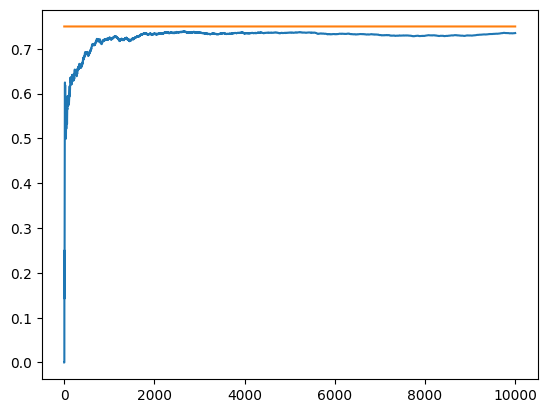

In [63]:
total = 10000
eps = 0
model_probs = [0.2, 0.5, 0.75]
experiment(model_probs, eps, total)